# Deep Neural Network in Tensorflow

## Set Up Session

In [1]:
# dataset:
from preprocessed_mnist import load_dataset
# processing:
import numpy as np
import tensorflow as tf
# visualization:
import matplotlib.pyplot as plt
%matplotlib inline

/home/alexge/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Prepare Dataset

In [2]:
# load dataset:
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()

In [3]:
y_train.dtype

dtype('uint8')

## Exploratory Analysis

In [4]:
# dataset dimensions:
N, H, W = X_train.shape
C = len(np.unique(y_train))

print("[Feature Size]: ({}, {}, {})".format(N, H, W))
print("[Label Size]: ({}, {})".format(N, C))

[Feature Size]: (50000, 28, 28)
[Label Size]: (50000, 10)


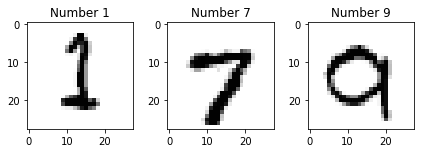

In [5]:
# draw samples:
num_samples = 3
indices = np.random.choice(N, num_samples)
# visualize them:
for plot_index, sample_index in enumerate(indices):
    plt.subplot(1, num_samples, plot_index + 1)
    plt.imshow(X_train[sample_index], cmap="Greys");
    plt.title("Number {}".format(y_train[sample_index]))
# adjust layout:
plt.tight_layout()

## Build Model

In [6]:
# init session:
sess = tf.InteractiveSession()

### Input Placeholders

In [7]:
# raw inputs:
feature = tf.placeholder(
    dtype = tf.float32, 
    shape = (None, H, W),
    name = 'feature'
)
label = tf.placeholder(
    dtype = tf.uint8,
    shape = [None],
    name = 'label'
)

### Processed Input

In [8]:
# processed inputs:
expanded = tf.reshape(
    feature,
    shape = (-1, H, W, 1)
)
encoded = tf.one_hot(
    label,
    depth = C,
    dtype = tf.float32,
    name = 'encoded'
)

### Model Definition

In [9]:
# convolution layers:
num_conv_1 = 32
num_conv_2 = 32
# fully-connected layers:
num_fully_connected_1 = 32

# first conv layer:
W1 = tf.Variable(
    tf.truncated_normal((3, 3, 1, num_conv_1), stddev=0.1),
    name = 'W1'
)
b1 = tf.Variable(
    tf.constant(0.1, shape=(num_conv_1,)),
    name = 'b1'
)
z1 = tf.nn.relu(
    tf.nn.conv2d(expanded, W1, strides=[1, 1, 1, 1], padding='SAME') + b1,
    name = 'z1'
)
h1 = tf.nn.max_pool(
    z1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name = 'h1'
)
# second conv layer:
W2 = tf.Variable(
    tf.truncated_normal((3, 3, num_conv_1, num_conv_2), stddev=0.1),
    name = 'W2'
)
b2 = tf.Variable(
    tf.constant(0.1, shape=(num_conv_2,)),
    name = 'b2'
)
z2 = tf.nn.relu(
    tf.nn.conv2d(h1, W2, strides=[1, 1, 1, 1], padding='SAME') + b2,
    name = 'z2'
)
h2 = tf.nn.max_pool(
    z2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name = 'h2'
)
# flattended:
flattended = tf.reshape(
    h2, shape = (-1, 7*7*num_conv_2)
)
# fully-connected layer:
W3 = tf.Variable(
    tf.truncated_normal((7*7*num_conv_2, num_fully_connected_1), stddev=0.1),
    name = 'W3'
)
b3 = tf.Variable(
    tf.constant(0.1, shape=(num_fully_connected_1,)),
    name = 'b3'
)
h3 = tf.nn.relu(
    tf.matmul(flattended, W3) + b3,
    name = 'h3'
)
# logits:
W_logits = tf.Variable(
    tf.truncated_normal((num_fully_connected_1, C), stddev=0.1),
    name = 'W_logits'
)
b_logits = tf.Variable(
    tf.constant(0.1, shape=(C,)),
    name = 'b_logits'
)
logits = tf.matmul(h3, W_logits) + b_logits
# loss:
loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(
        labels = encoded, 
        logits = logits
    )
)
# optimizer:
optimizer = tf.train.AdamOptimizer(1e-3).minimize(loss)
# accuracy:
accuracy = tf.reduce_mean(
    tf.cast(
        tf.equal(tf.argmax(encoded, 1), tf.argmax(logits,1)), 
        tf.float32
    )
)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



### Training

In [10]:
# config:
num_epoches = 25

batch_size = 10000
num_iterations = int(N / batch_size) + 1

evaluation_step = 5

learning_rate = 5e-3

In [11]:
# optimizer:
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
# initialize variables:
sess.run(tf.global_variables_initializer())
# logging:
train_accuracies = []
valid_accuracies = []
# training:
step_index = 0
for epoch_index in range(num_epoches):
    for iteration_index in range(num_iterations):
        # draw mini batch:
        batch_indices = np.random.choice(N, batch_size)
        X_batch, y_batch = X_train[batch_indices], y_train[batch_indices]
        # train on mini batch
        _, train_accuracy = sess.run(
            [optimizer, accuracy],
            feed_dict = {
                feature: X_batch,
                label: y_batch
            }
        )
        # evaluation:
        step_index += 1
        if step_index % evaluation_step == 0:
            valid_accuracy = sess.run(
                accuracy,
                feed_dict = {
                    feature: X_val,
                    label: y_val
                }           
            )
            print(
                "[Training]: {:.2f}%    [Validation]: {:.2f}%".format(
                    100*train_accuracy, 
                    100*valid_accuracy
                )
            )
            # add to logging:
            train_accuracies.append(train_accuracy)
            valid_accuracies.append(valid_accuracy)

[Training]: 10.42%    [Validation]: 33.99%
[Training]: 49.91%    [Validation]: 55.66%
[Training]: 69.81%    [Validation]: 72.61%
[Training]: 78.09%    [Validation]: 79.37%
[Training]: 83.88%    [Validation]: 83.02%
[Training]: 84.02%    [Validation]: 86.86%
[Training]: 86.79%    [Validation]: 88.65%
[Training]: 87.94%    [Validation]: 89.90%
[Training]: 89.72%    [Validation]: 90.91%
[Training]: 90.68%    [Validation]: 91.83%
[Training]: 90.97%    [Validation]: 91.97%
[Training]: 91.74%    [Validation]: 92.54%
[Training]: 91.85%    [Validation]: 93.24%
[Training]: 92.31%    [Validation]: 93.72%
[Training]: 92.94%    [Validation]: 94.22%
[Training]: 93.68%    [Validation]: 94.70%
[Training]: 94.04%    [Validation]: 94.96%
[Training]: 94.53%    [Validation]: 95.25%
[Training]: 94.80%    [Validation]: 95.50%
[Training]: 95.11%    [Validation]: 95.84%
[Training]: 95.49%    [Validation]: 96.03%
[Training]: 95.87%    [Validation]: 96.20%
[Training]: 96.21%    [Validation]: 96.33%
[Training]:

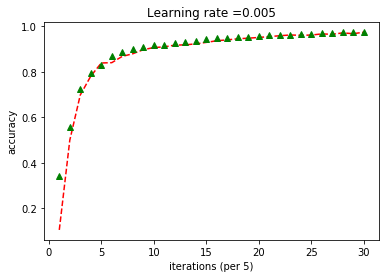

In [13]:
# visualize process:
steps = range(1, len(train_accuracies) + 1)
plt.plot(steps, train_accuracies, 'r--', steps, valid_accuracies, 'g^')
plt.ylabel('accuracy')
plt.xlabel("iterations (per {})".format(evaluation_step))
plt.title("Learning rate =" + str(learning_rate))
plt.show()

## Evaluation

In [14]:
test_accuracy = sess.run(
    accuracy,
    feed_dict = {
        feature: X_test,
        label: y_test
    }           
)

In [15]:
print("[Testing]: {:.2f}%".format(100*test_accuracy))

[Testing]: 97.43%
